In [8]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

In [9]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression

In [10]:
df = pd.read_csv('WA_Fn-UseC_-Telco-Customer-Churn.csv')

df.columns = df.columns.str.lower().str.replace(' ', '_')

categorical_columns = list(df.dtypes[df.dtypes == 'object'].index)

for c in categorical_columns:
    df[c] = df[c].str.lower().str.replace(' ', '_')

df.totalcharges = pd.to_numeric(df.totalcharges, errors='coerce')
df.totalcharges = df.totalcharges.fillna(0)

df.churn = (df.churn == 'yes').astype(int)

In [11]:
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

y_train = df_train.churn.values
y_val = df_val.churn.values
y_test = df_test.churn.values

del df_train['churn']
del df_val['churn']
del df_test['churn']

In [12]:
numerical = ['tenure', 'monthlycharges', 'totalcharges']

categorical = [
    'gender', 
    'seniorcitizen', 
    'partner', 
    'dependents',
    'phoneservice', 
    'multiplelines', 
    'internetservice',
    'onlinesecurity', 
    'onlinebackup', 
    'deviceprotection', 
    'techsupport',
    'streamingtv', 
    'streamingmovies', 
    'contract', 
    'paperlessbilling',
    'paymentmethod'
]

In [13]:
dv = DictVectorizer(sparse=False)

train_dict = df_train[categorical + numerical].to_dict(orient='records')
X_train = dv.fit_transform(train_dict)

model = LogisticRegression(max_iter=10000)
model.fit(X_train, y_train)

LogisticRegression(max_iter=10000)

In [14]:
val_dict = df_val[categorical + numerical].to_dict(orient='records')
X_val = dv.transform(val_dict)

y_pred = model.predict_proba(X_val)[:, 1]
churn_decision = (y_pred >= 0.5)
(y_val == churn_decision).mean()

np.float64(0.8034066713981547)

## Accuracy and Dummy Model

In [16]:
len(y_val)

1409

In [18]:
(y_val == churn_decision).sum() #correct decisions

np.int64(1132)

In [21]:
thresholds = np.linspace(0, 1, 21)

scores = []

for t in thresholds:
    churn_decision = (y_pred >= t)
    score = (y_val == churn_decision).mean()
    print('%.2f %.3f' % (t, score))
    scores.append(score)

0.00 0.274
0.05 0.513
0.10 0.608
0.15 0.662
0.20 0.703
0.25 0.735
0.30 0.758
0.35 0.764
0.40 0.782
0.45 0.791
0.50 0.803
0.55 0.802
0.60 0.796
0.65 0.789
0.70 0.766
0.75 0.742
0.80 0.729
0.85 0.726
0.90 0.726
0.95 0.726
1.00 0.726


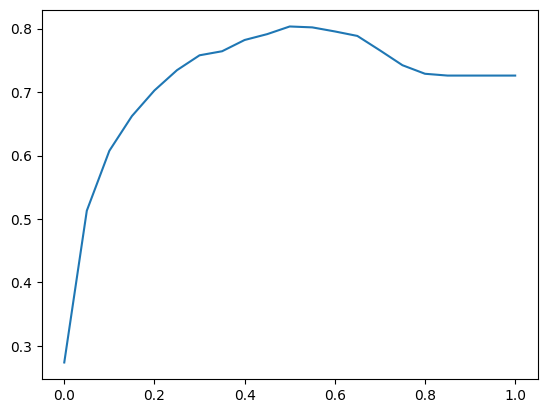

In [22]:
plt.plot(thresholds, scores)

In [23]:
from sklearn.metrics import accuracy_score

In [25]:
accuracy_score(y_val, y_pred >= 0.5)

0.8034066713981547

In [26]:
thresholds = np.linspace(0, 1, 21)

scores = []

for t in thresholds:
    score = accuracy_score(y_val, y_pred >= t)
    print('%.2f %.3f' % (t, score))
    scores.append(score)

0.00 0.274
0.05 0.513
0.10 0.608
0.15 0.662
0.20 0.703
0.25 0.735
0.30 0.758
0.35 0.764
0.40 0.782
0.45 0.791
0.50 0.803
0.55 0.802
0.60 0.796
0.65 0.789
0.70 0.766
0.75 0.742
0.80 0.729
0.85 0.726
0.90 0.726
0.95 0.726
1.00 0.726


In [27]:
from collections import Counter

In [28]:
Counter(y_pred >= 1.0)

Counter({np.False_: 1409})

In [29]:
Counter(y_val) 
# class imbalance -> there is a lot more data for non churning -> 3:1 ratio 

Counter({np.int64(0): 1023, np.int64(1): 386})